In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
from torch.utils.data import Dataset, DataLoader, random_split
from PIL import Image
from torchvision import transforms
import torch.nn as nn
import random
import torch
from utils import unet, mypreprocess, util_functions
from tqdm import tqdm
import segmentation_models_pytorch as smp
from segmentation_models_pytorch.losses import DiceLoss
import json
import warnings
warnings.filterwarnings("ignore")

/home/student/sinaziaee/mini_conda/miniconda3/envs/test/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# path_dir = os.path.join(os.getcwd(), 'Human-Segmentation-Dataset-master')
# image_dir = os.path.join(path_dir, 'Training_Images')
# label_dir = os.path.join(path_dir, 'Ground_Truth')
# map_dir_path = os.path.join(path_dir, 'train.csv')

path_dir = os.path.join('/scratch/student/sinaziaee/datasets/2d_dataset', 'training')
image_dir = os.path.join(path_dir, 'images')
label_dir = os.path.join(path_dir, 'labels')
transform = mypreprocess.create_transformer(img_size=512)
batch_size = 74
train_loader, valid_loader, test_loader = mypreprocess.create_data_loaders(path_dir=path_dir, image_dir=image_dir, 
                                            label_dir=label_dir, data_transformer=transform, batch_size=batch_size, split_size=[0.9, 0.1])

In [19]:
len(train_loader), len(valid_loader), len(test_loader)

(183, 21, 1)

In [6]:
def train_fn(data_loader, model, criterion, optimizer, device, criterion2=None, is_parallel=False, device_0=None, device_1=None):
    model.train()
    total_loss = 0
    for batch in data_loader:
        if is_parallel is False:
            images, masks = batch
            images = images.to(device)
            masks = masks.to(device)
        else:
            images, masks = batch[0].to(device_0), batch[1].to(device_1)
        
        outputs = model(images)
        
        optimizer.zero_grad() 
        # print(outputs.shape) 
        # print(masks.shape)
        loss1 = criterion(outputs, masks)
        if criterion2 is not None:
            loss2 = criterion2(outputs, masks)
            loss = loss1 + loss2
        else:
            loss = loss1
        total_loss += loss.item()
        loss.backward()
        optimizer.step()
    
    avg_loss = total_loss / len(data_loader)
    return avg_loss

In [7]:
def eval_fn(data_loader, model, criterion, device, criterion2=None, is_parallel=False, device_0=None, device_1=None):
    model.eval()
    total_loss = 0
    total_iou = 0
    with torch.no_grad():
        for batch in data_loader:
            if is_parallel is False:
                images, masks = batch
                images = images.to(device)
                masks = masks.to(device)
            else:
                images, masks = batch[0].to(device_0), batch[1].to(device_1)
            
            outputs = model(images)
            if criterion2 == None:
                loss = criterion(outputs, masks)
            else:
                loss = criterion(outputs, masks) + criterion2(outputs, masks)
            total_loss += loss.item()
            iou = util_functions.calculate_IoU(outputs, masks)
            total_iou += iou.item()
            # dice_value = dice_coefficient2(masks, outputs)
            dice_value = 0
        
        avg_loss = total_loss / len(data_loader)
        avg_iou = total_iou / len(data_loader)
    return avg_loss, avg_iou, dice_value

In [8]:
def train_loop(n_epochs, model, optimizer, train_loader, valid_loader, device,
                                criterion1, criterion2 = None, device_0 = None, device_1 = None, is_parallel=True):
    if is_parallel is False:
        model = model.to(device)
    else:
        model = nn.DataParallel(model, device_ids=[0, 1])
        
    best_valid_loss = np.Inf

    train_loss_list = []
    valid_loss_list = []
    valid_iou_list = []
    valid_dice_list = []

    results_folder = util_functions.create_result_folder(path='results')

    for epoch in tqdm(range(n_epochs)):
        train_loss = train_fn(data_loader=train_loader, model=model, criterion=criterion1, 
                              optimizer=optimizer, device=device, criterion2=criterion2,
                              is_parallel=is_parallel, device_0=device_0, device_1=device_1)
        valid_loss, valid_iou, valid_dice = eval_fn(data_loader=valid_loader, model=model, criterion=criterion1,
                                        device=device, criterion2=criterion2,
                                        is_parallel=is_parallel, device_0=device_0, device_1=device_1)
        
        train_loss_list.append(train_loss)
        valid_loss_list.append(valid_loss)
        valid_iou_list.append(valid_iou)
        valid_dice_list.append(valid_dice)
        
        if best_valid_loss > valid_loss:
            best_valid_loss = valid_loss
            directory = 'results'
            if not os.path.exists(directory):
                os.makedirs(directory)
            torch.save(model.state_dict(), f'results/{results_folder}/best_model.pt')
            print('SAVED-MODEL')
        
        if epoch % 10 == 0:
            print(f'Epoch: {epoch+1}, Train Loss: {train_loss}, Valid Loss: {valid_loss}')
            util_functions.visualize_training(train_loss_list=train_loss_list, valid_loss_list=valid_loss_list,
                                            valid_iou_list=valid_iou_list, valid_dice_list=valid_dice_list, results_folder=results_folder)
            
        lists_dict = {
            'train_loss_list': train_loss_list,
            'valid_loss_list': valid_loss_list,
            'valid_iou_list': valid_iou_list,
            'valid_dice_list': valid_dice_list,
        }

        with open(f'results/{results_folder}/training_trend.json', 'w') as f:
            json.dump(lists_dict, f)
                

In [9]:
is_parallel = False
# Parallel training
model = unet.UNet(num_classes=1, input_channels=1)
# model = smp.Unet(classes=1, in_channels=1)
# model.load_state_dict(torch.load('results/best_model.pt'))
device = torch.device('cuda:1')
device_0 = torch.device('cuda:0')
device_1 = torch.device('cuda:1')
if is_parallel is True:
    model.to(device_0)
    model.to(device_1)
    model = nn.DataParallel(model, device_ids=[0, 1])
else:
    model.to(device)
print(device)

cuda:1


  0%|          | 0/71 [00:00<?, ?it/s]

SAVED-MODEL
Epoch: 1, Train Loss: 0.9128506668929846, Valid Loss: 0.8789697175934201


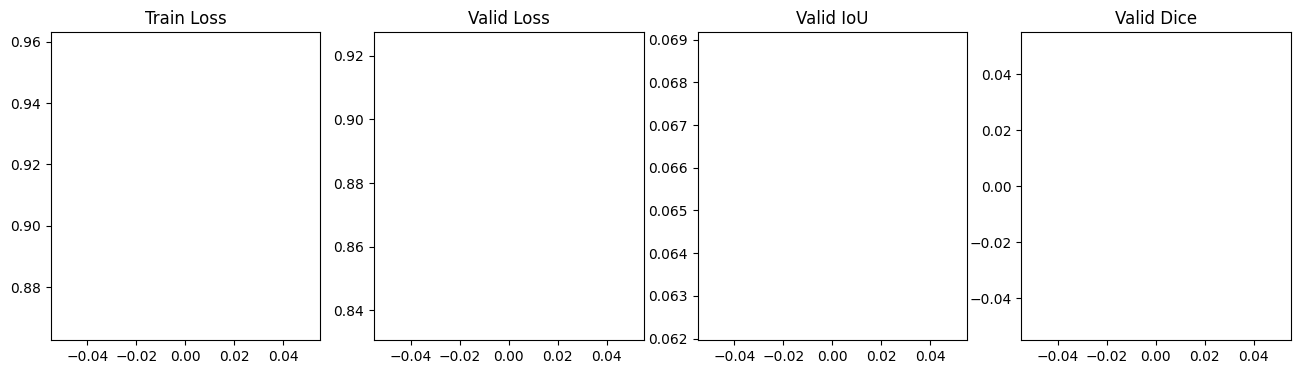

  3%|▎         | 2/71 [08:01<4:31:29, 236.09s/it]

SAVED-MODEL


  6%|▌         | 4/71 [14:47<3:58:32, 213.61s/it]

SAVED-MODEL


  7%|▋         | 5/71 [18:09<3:50:29, 209.54s/it]

SAVED-MODEL


 13%|█▎        | 9/71 [31:38<3:30:36, 203.81s/it]

SAVED-MODEL


 14%|█▍        | 10/71 [35:01<3:26:45, 203.37s/it]

Epoch: 11, Train Loss: 0.6012449225441354, Valid Loss: 0.746112204733349


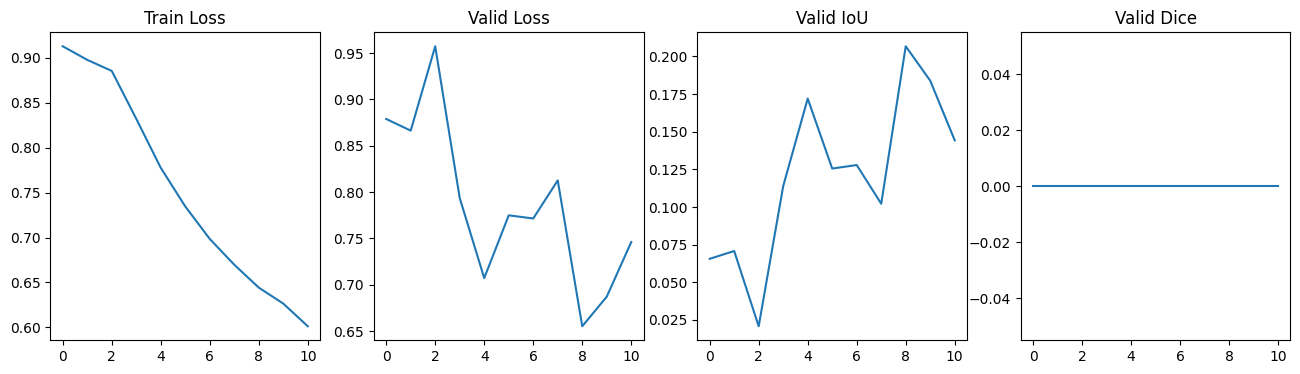

 18%|█▊        | 13/71 [45:08<3:15:59, 202.75s/it]

SAVED-MODEL


 24%|██▍       | 17/71 [58:37<3:02:07, 202.36s/it]

SAVED-MODEL


 28%|██▊       | 20/71 [1:08:43<2:51:52, 202.20s/it]

SAVED-MODEL
Epoch: 21, Train Loss: 0.5155015698547571, Valid Loss: 0.508435050646464


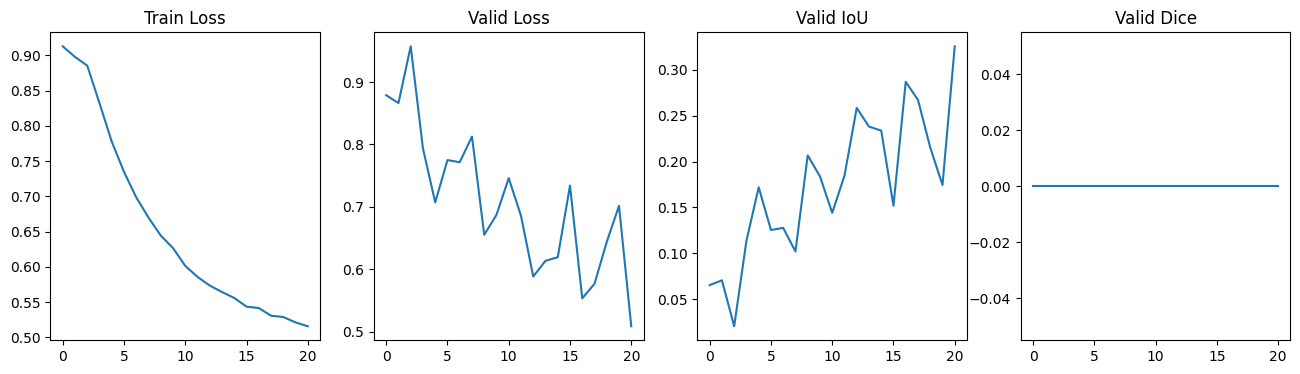

 32%|███▏      | 23/71 [1:18:51<2:41:55, 202.40s/it]

SAVED-MODEL


 41%|████      | 29/71 [1:39:04<2:21:30, 202.16s/it]

SAVED-MODEL


 42%|████▏     | 30/71 [1:42:26<2:18:10, 202.20s/it]

Epoch: 31, Train Loss: 0.48547164566529905, Valid Loss: 0.5316517778805324


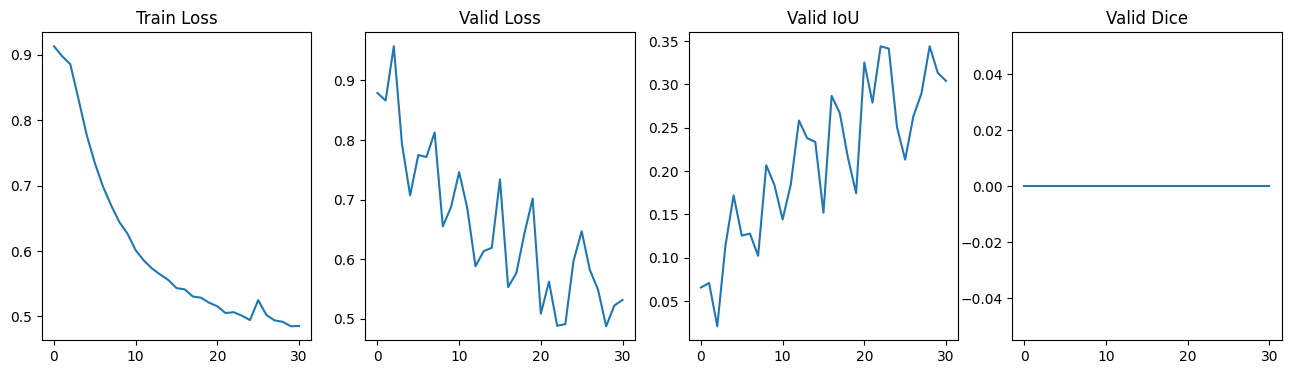

 52%|█████▏    | 37/71 [2:06:02<1:54:34, 202.20s/it]

SAVED-MODEL


 54%|█████▎    | 38/71 [2:09:24<1:51:14, 202.24s/it]

SAVED-MODEL


 56%|█████▋    | 40/71 [2:16:08<1:44:27, 202.17s/it]

Epoch: 41, Train Loss: 0.4587733745574951, Valid Loss: 0.45123130083084106


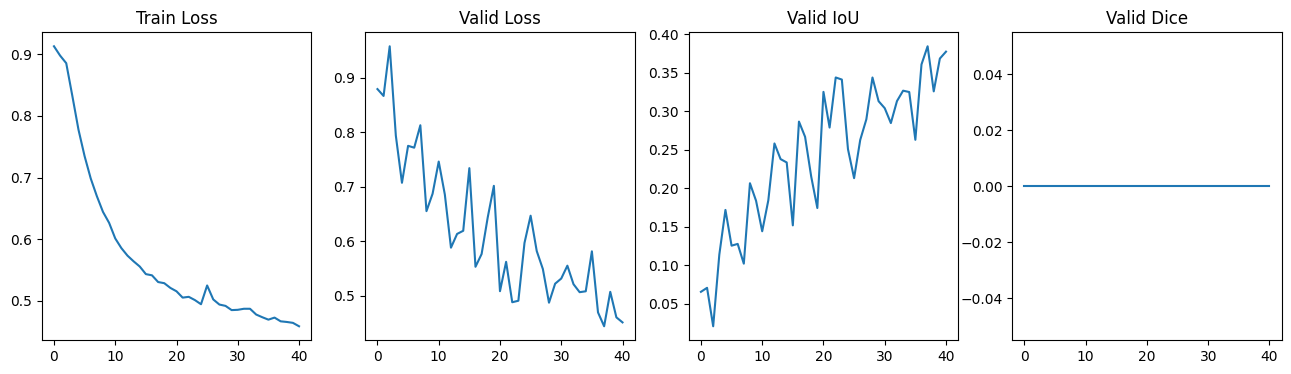

 70%|███████   | 50/71 [2:49:50<1:10:44, 202.13s/it]

Epoch: 51, Train Loss: 0.447430926268218, Valid Loss: 0.490021546681722


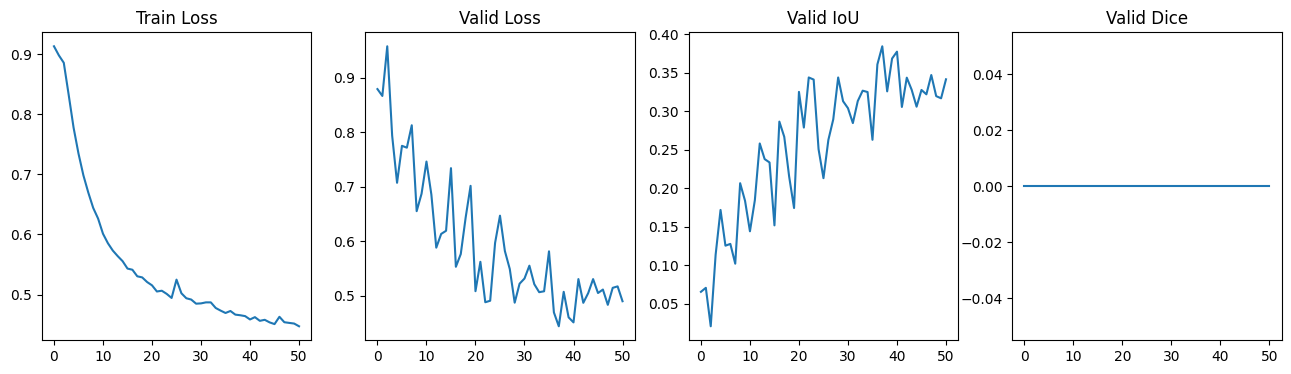

 85%|████████▍ | 60/71 [3:23:31<37:03, 202.14s/it]  

Epoch: 61, Train Loss: 0.4368034451385665, Valid Loss: 0.6069186131159464


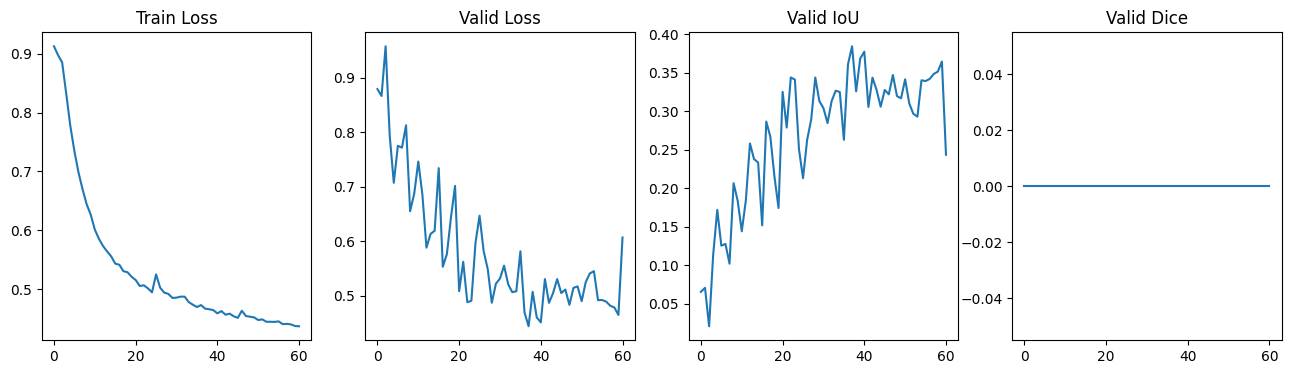

 87%|████████▋ | 62/71 [3:30:16<30:19, 202.18s/it]

SAVED-MODEL


 99%|█████████▊| 70/71 [3:57:13<03:22, 202.18s/it]

Epoch: 71, Train Loss: 0.43012714809407304, Valid Loss: 0.47183569840022493


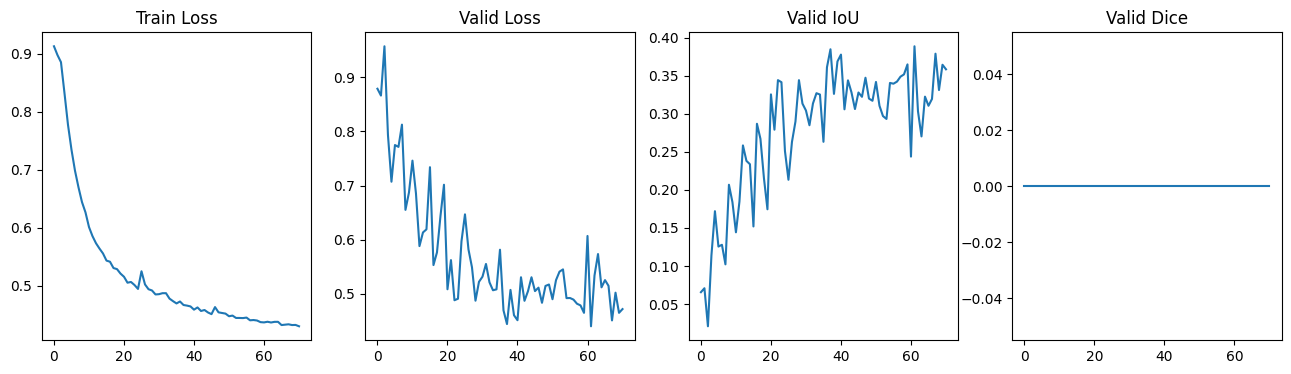

100%|██████████| 71/71 [4:00:36<00:00, 203.32s/it]


In [13]:
criterion1 = DiceLoss(mode="binary")
criterion2 = nn.BCEWithLogitsLoss()
learning_rate = 0.001
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
n_epochs = 71

train_loop(n_epochs, model, optimizer, train_loader, valid_loader, device, criterion1, None,
                        is_parallel=is_parallel, device_0=device_0, device_1=device_1)

In [14]:
torch.cuda.empty_cache()

In [33]:
model = unet.UNet(num_classes=1, input_channels=1)
# model = smp.Unet(classes=1, in_channels=1)
model.load_state_dict(torch.load('results/best_model.pt'))
# device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device = torch.device('cuda:1')
device_0 = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device_1 = torch.device('cuda:1' if torch.cuda.is_available() else 'cpu')
if is_parallel is True:
    model.to(device_0)
    model.to(device_1)
    model = nn.DataParallel(model, device_ids=[0, 1])
else:
    model.to(device)
print(device)

cuda:1


In [ ]:
train_loop(n_epochs, model, optimizer, train_loader, valid_loader, device, criterion1, None,
                        is_parallel=is_parallel, device_0=device_0, device_1=device_1)

In [17]:
idx = 30
model.load_state_dict(torch.load('results/best_model.pt'))
data_iter = iter(valid_loader)
images, masks = next(data_iter)
image = images[idx]
mask = masks[idx]
logits_mask = model(image.to(device).unsqueeze(0))
pred_mask = torch.sigmoid(logits_mask)
pred_mask = (pred_mask > 0.5) * 1.0

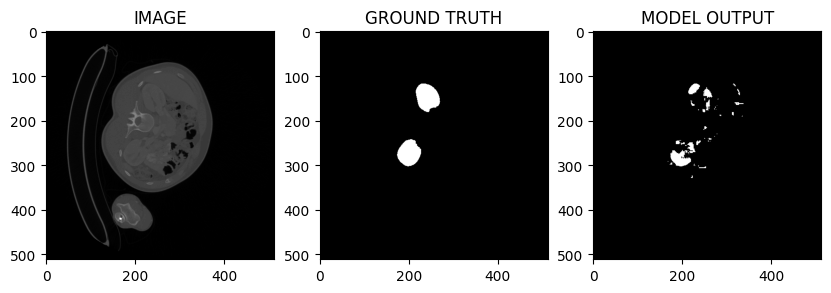

In [18]:
util_functions.show_image(image, mask, pred_mask.detach().cpu().squeeze(0))

In [15]:
model = unet.UNet(input_channels=1, num_classes=1)
model.load_state_dict(torch.load('results/best_model.pt'))
model = model.to(device)

  0%|          | 0/500 [00:00<?, ?it/s]

SAVED-MODEL
Epoch: 1, Train Loss: 0.7166332229971886, Valid Loss: 0.33545786142349243


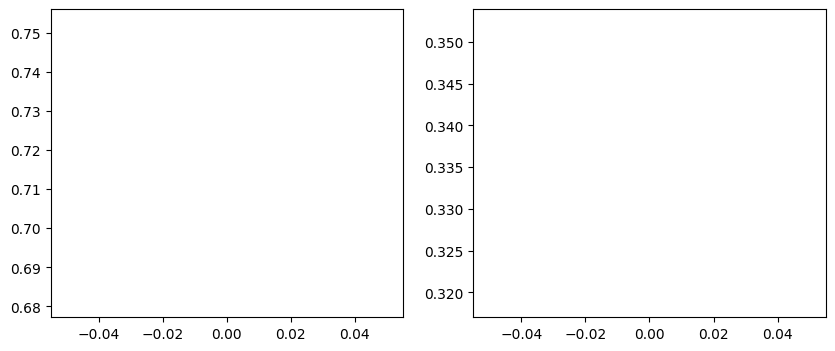

 10%|█         | 50/500 [47:29<7:08:19, 57.11s/it]

Epoch: 51, Train Loss: 0.7128799110651016, Valid Loss: 0.33545786142349243


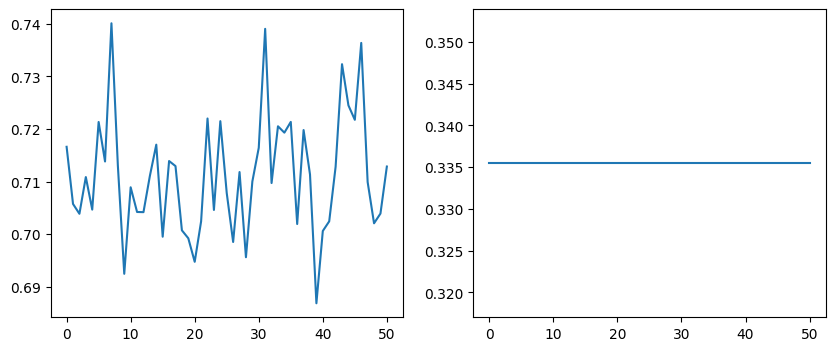

 20%|██        | 100/500 [1:34:22<6:43:47, 60.57s/it]

Epoch: 101, Train Loss: 0.7238178551197052, Valid Loss: 0.33545786142349243


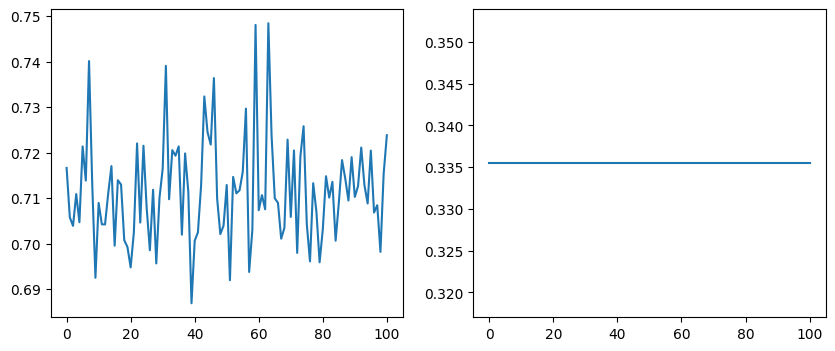

 21%|██        | 105/500 [1:40:02<6:16:20, 57.16s/it]


KeyboardInterrupt: 

In [18]:
train_loop(n_epochs, model, optimizer, train_loader, valid_loader, device, criterion1, criterion2)